# Analyzing Gapminder dataset using python
## Indiana University, Bloomington
## Applied Data Science - SPR-19, Date : 27 -Apr-2019
### Questions
 - How the data is distributed, do we observe normal or skewed distributions among variables?
 - What is most densely populated region and country?
 - What are the regions or countries that have the highest life expectancy and income?
 - What is average growth in population over the years?
 - How the life expectancy has been changed over the regions, does latest medicine inventions helped to improve life expectancy?
 - Do we have any correlation between the variables?
 - Can we predict the life expectancy? what are the most powerful features to perform regression?
 - Can we statistically test the model ?
 - What property does the residual shows heteroscedasticity or homoscedasticity?
 - Can we build unsupervised model, to classify input data into various classes that represent regions?
 - If yes, what optimal number of clusters need to fit data?
 - Do we have accuracy metrics to represent cluster assignment?

# Dataset Details

In [1]:
# Load Necessary Libraries

import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns 
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import Dataset
# Use standard pandas read_csv method to import the dataset into memory
df = pd.read_csv("../Data/gapminder.csv")

In [3]:
# Describe Your dataset
def describe_data(df):   
    # Check the column data Types
    print('*'*50)
    print('Dataset information \n')
    print(df.info())
    # Useful isna function to check sum for Null/Na values
    print('*'*50)
    print('Nulls / missing values\n')
    print(df.isna().sum())
    # Describe gives us summary statistics on numerical columns
    print('*'*50)
    print('Summary Statistics\n')
    print(df.describe())
    # head command allows us to see sample rows , you can pass argument 'n' as number rows you want to sample for 
    # e.g df.head(10) will Display first 10 rows 
    print('*'*50)
    print('Unique countries and Regions\n')
    print("Unique Countries: ",df['Country'].nunique())
    print("Unique Regions: ",df['region'].nunique())

describe_data(df)

**************************************************
Dataset information 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41284 entries, 0 to 41283
Data columns (total 6 columns):
Country       41284 non-null object
Year          41284 non-null int64
life          41284 non-null float64
population    15467 non-null object
income        38943 non-null float64
region        41284 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 1.9+ MB
None
**************************************************
Nulls / missing values

Country           0
Year              0
life              0
population    25817
income         2341
region            0
dtype: int64
**************************************************
Summary Statistics

               Year          life         income
count  41284.000000  41284.000000   38943.000000
mean    1907.462504     42.884766    4570.795214
std       62.241440     16.220812   10096.543747
min     1800.000000      1.000000     142.000000
25%     185

The dataset contains total of 41,284 rows (instance/observations) and 6 columns (features/variables). Three of the columns have object datatype while the remaining three have float/int datatypes.

There is the presence of wrong data type for the population column; hence we could not get the summary statistics; it needs conversion to numeric.

Also, there are missing values (NaN) in population and income section. The Gapminder dataset contains census information about 197 countries and 6 regions.

In Summary statistics, we can see Year column, with the oldest to latest values 1800 and 2015 respectively. Without any modification, the raw data average life expectancy is close to 43 years while the average income which I presume to GDP per capita is 4570.

# Preprocessing
**Convert columns to appropiate datatypes**

The population column contains some observations that contain numbers with commas. Using Pandas replace method we can convert the population column to float.

**Scaling and Normalizing for better correlations and models**

If we want to compare or find relationships in two different scale variables, it is crucial to scale them on the same units. We see a correlation between life and income column; however, they both are having different units. In such a case, we can take a log of income column that produces better correlation and also normalizes the data for that column

_Before Normalizing Correlation in life expectancy and income_

In [7]:
df['income'].corr(df['life'])

0.5764090225927695

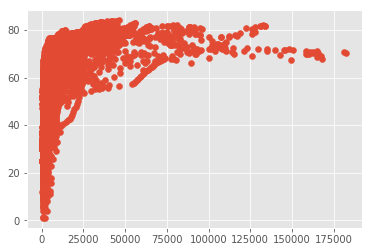

In [8]:
plt.style.use('ggplot')
plt.figure(figsize=(6,4))
plt.scatter(df['income'],df['life']);


As part of the project we also need to build machine learning models. Hence it was also important to scale the variables so as to measure the correlations correctly. We can see immediate improvement in pearson correlation coefficient

**After Normalizing Correlation in life expectancy and income**

In [9]:
np.log10(df['income']).corr(df['life'])

0.8183561134086763

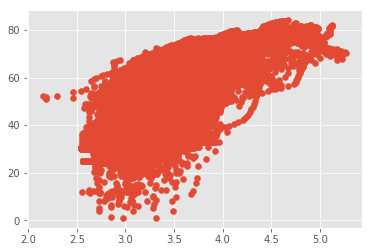

In [10]:
plt.figure(figsize=(6,4))
plt.scatter(np.log10(df['income']),df['life'],marker='o');

**Handling missing values**
In the real-world dataset, we find the datasets with missing values, it is essential to handle them carefully. As specific calculations cannot work when the dataset is containing missing values this is especially true when building a machine learning model. There are several strategies to handle the missing data. E.g., working with time series data, we can use a forward/backward fill. For numeric columns, we can use the imputation technique and use relevant statistics such as mean or median. Here I decided to impute the NaN values using Pandas group by and transform method. This step is crucial in my analysis as it prevents inflating of resulting dataset, it would not be appropriate to impute missing values directly using column means, since the median or mean for an entire column could be very high.

**Write a function that does all of above**

In [11]:
print('Dataset shape before cleaning and imputing and scaling: ',df.shape)

Dataset shape before cleaning and imputing and scaling:  (41284, 6)


In [12]:
# Function that imputes mean and median

def impute_mean(series):
    return series.fillna(series.mean())

def impute_median(series):
    return series.fillna(series.median())

# Function to clean the data frame

def preprocessing(df):
    df.population = df.population.str.replace(",","").astype(float)
    by_country_region = df.groupby(['Country'])
    by_region = df.groupby(['region'])
    df.income = by_country_region['income'].transform(impute_mean)
    df.population = by_country_region['population'].transform(impute_mean)
    
    # despite imputing some countries still have null values as there is no historical information available for
    # any of the rows, however I decided to impute median values by region in income column for such rows.
    
    df.income = by_region['income'].transform(impute_median)
    
    # I will create a new variable which will be useful when analyzing the relationships
    # This will be also useful in machine learning regression model.
    
    df['log_income'] = np.log1p(df['income'])
    
    return df

In [13]:
# Call the clean data 
df = preprocessing(df)
# As we imputed the data there are no null values
df.isna().sum()

Country       0
Year          0
life          0
population    0
income        0
region        0
log_income    0
dtype: int64

In [14]:
# The transformations have taken place, population column is now numeric and new variable introduced 'log_income'
df.describe()

,Year,life,population,income,log_income
count,41284.000000,41284.000000,4.128400e+04,41284.000000,41284.000000
mean,1907.462504,42.884766,2.119029e+07,4407.123878,7.570855
std,62.241440,16.220812,8.604116e+07,9830.406088,1.085593
min,1800.000000,1.000000,1.548000e+03,142.000000,4.962845
25%,1854.000000,31.000000,6.617537e+05,890.000000,6.792344
50%,1908.000000,35.118539,3.718155e+06,1461.000000,7.287561
75%,1962.000000,55.600000,1.185808e+07,3258.000000,8.089176
max,2015.000000,84.100000,1.376049e+09,182668.000000,12.115431


In [15]:
print('Dataset shape After cleaning and imputing and scaling : ',df.shape)

Dataset shape After cleaning and imputing and scaling :  (41284, 7)


# Exploratory Data Analysis
Instead of dropping half dataset, we are still holding on most of the data which would be useful for analysis and as well for model building.

Data visualization comes in handy that lets you discover trends or patterns in a data set and are often referred to as Exploratory Data analysis.

Histograms visualization are great at showing outliers and displaying how the data distributions. Not all variables normally distributed. Hence we can make incorrect conclusions by assuming normality.

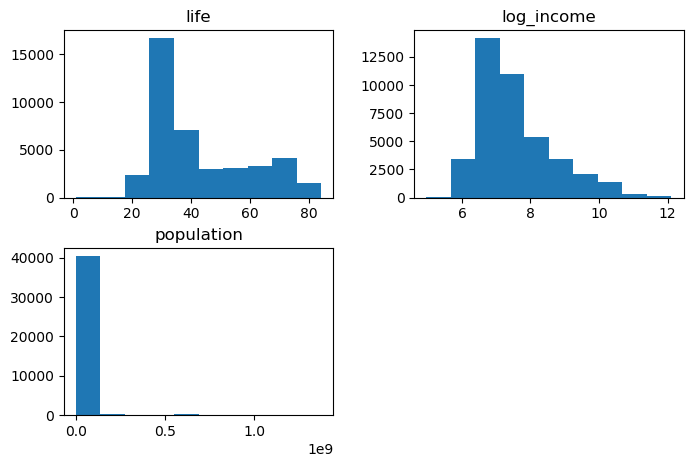

In [16]:
plt.style.use('default')
df[['log_income','life','population']].hist(figsize=(8,5),grid=False);

We can see a Power-law distribution for the population column with fat tail mainly due to largely populated countries. The log_income column is not perfectly normally distributed, some countries pulling the tail due to high income(GDP). Also, life expectancy column has skewed distributions, the life expectancy seems very low 30 - 40 overall.

Box plots are a common visualization for displaying the general shape of distribution using intervals, let's explore the life expectancy for each region.

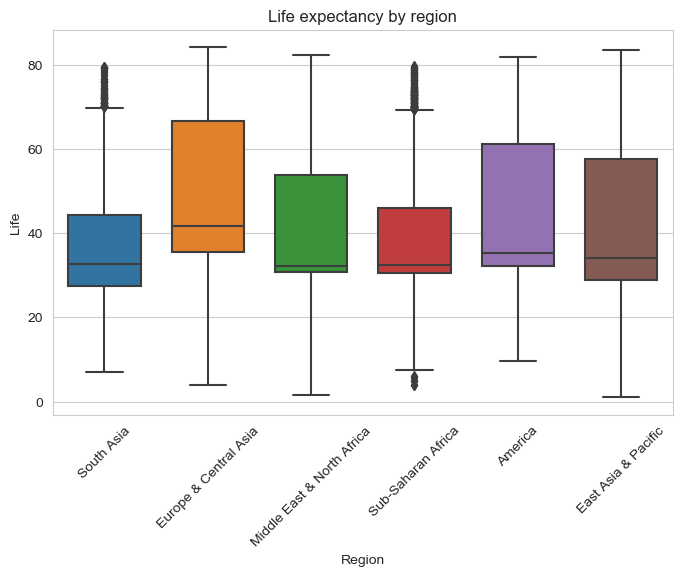

In [17]:
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")
sns.boxplot(x="region", y="life",data=df,color=None,palette=None,width=0.7)
plt.xticks(rotation=45)
plt.title('Life expectancy by region')
plt.xlabel('Region')
plt.ylabel('Life');


As we can see the median life expectancy for most of the regions lies between 30-40. The median life expectancy of Europe and Central Asia is highest followed life expectancy America, East Asia, and Pacific. However, This results also provokes question that why does life expectancy is so low. Let's break down the data by Years.

It is visible the median life expectancy has been shifted drastically after 1950, and this could also be verified through time series analysis, and I am going to cover in later sections.

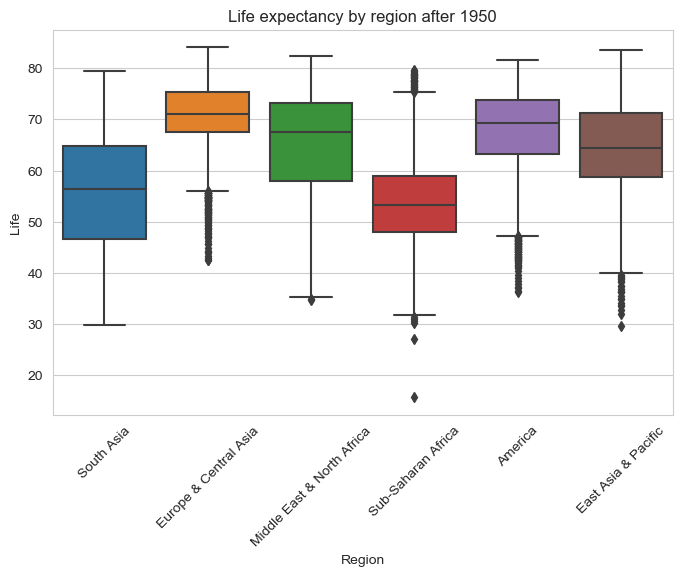

In [18]:
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")
sns.boxplot(x="region", y="life",data=df[df['Year']>=1950])
plt.xticks(rotation=45)
plt.title('Life expectancy by region after 1950')
plt.xlabel('Region')
plt.ylabel('Life');


If we want to look at how the data is distributed between the categories, Bar graphs are great here. Let begin to analyze the categorical data starting with income across regions.

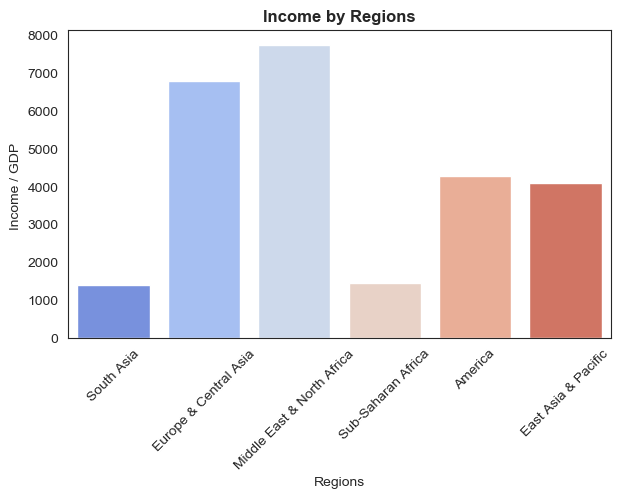

In [19]:
plt.figure(figsize=(7,4))
sns.set_style("white")
sns.barplot(x='region',y='income',data=df,ci=None,palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Income by Regions",fontweight="bold")
plt.xlabel("Regions")
plt.ylabel("Income / GDP ") ;


The Middle East and North Africa have the highest income or GDP per capita. They are followed by Europe & Central Asia and America and the remaining regions. It would be interesting to verify this finding by seeing the top countries in these regions.

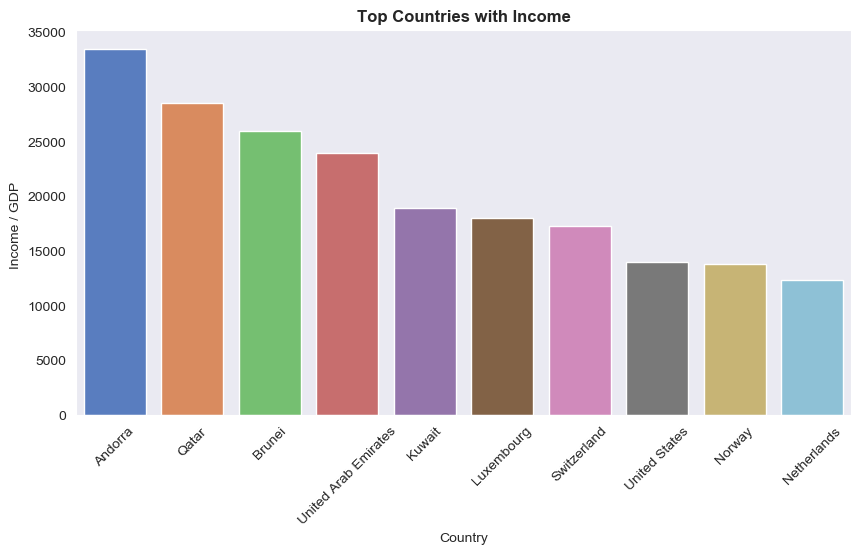

In [21]:
plt.figure(figsize=(10,5))
sns.set_style('dark')
df_cp = df.groupby(['Country'],as_index=False).mean().sort_values(by='income',ascending=False).iloc[:10]
sns.barplot(x='Country',y='income',data=df_cp,palette='muted',estimator=np.mean)
plt.title('Top Countries with Income',fontweight="bold")
plt.xticks(rotation=45)
plt.xlabel("Country")
plt.ylabel("Income / GDP ");

Andorra seems to have the highest GDP. Andorra is the smallest country in Europe and located between the border of France and Spain. One of the prime reason could be its tourism industry. The observations from the above bar chart show maximum countries are from Europe & Middle East which inline with our region level analysis. Next category to explore would be population by the region.

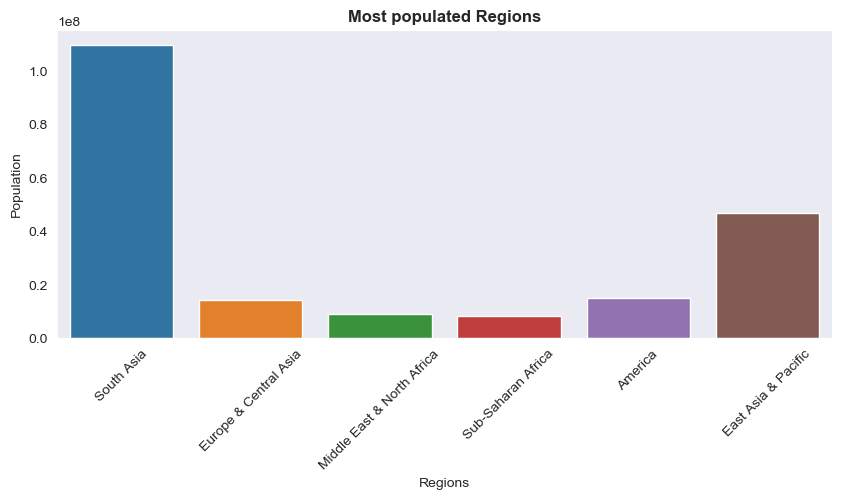

In [22]:
plt.figure(figsize=(10,4))
plt.ticklabel_format(axis='y')
sns.set_style('dark')
sns.barplot(x='region',y=df['population'],data=df,ci=None)
plt.xticks(rotation=45)
plt.title('Most populated Regions',fontweight="bold")
plt.xlabel("Regions")
plt.ylabel("Population");

South Asia most densely populated region followed by East Asia & Pacific and America

In [23]:
df_cn = df.groupby(['region','Country'],as_index=False).mean().sort_values(by='population',ascending=False).iloc[:8]

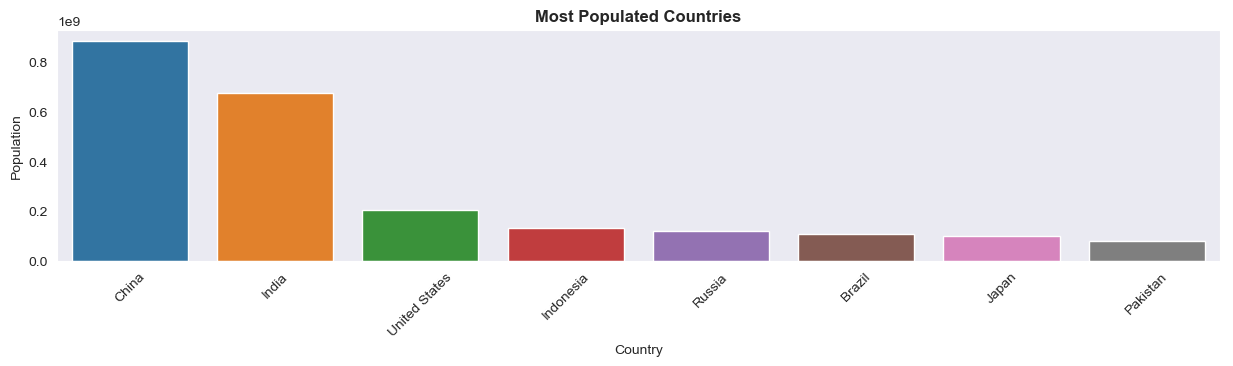

In [24]:
plt.figure(figsize=(15,3))
sns.barplot(x='Country',y=(df_cn['population']),data=df_cn,estimator=np.mean)
plt.title('Most Populated Countries',fontweight="bold")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.ylabel("Population");

Not surprisingly China and India are most populated countries

Time series charts are useful to see the changes in data or quantity concerning time. It is exceedingly useful while doing forecasting as it shows gradual changes and exposes time as one of the critical features. As we have seen from boxplot sharp rise in life expectancy lets validate with line charts for population life expectancy both.

In [25]:
# only consider the beyond 1950 (just see if we sharp rise)
growth = df[df['Year']>1950].groupby(['Year','region']).population.mean().unstack()

**South Asia population growth post 1950 is astonishing**

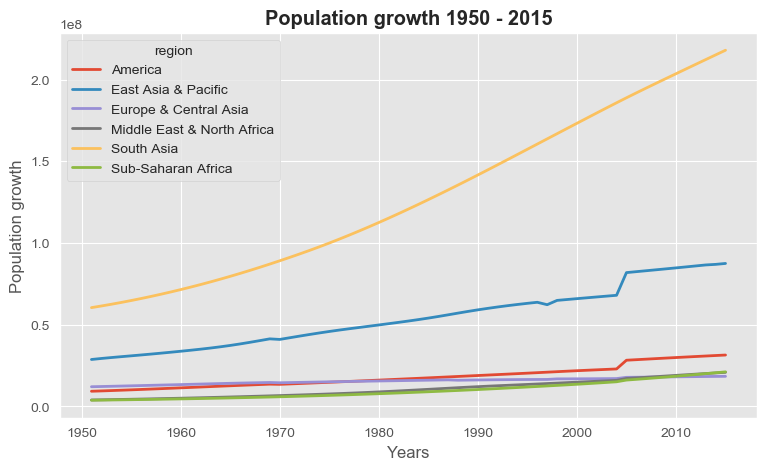

In [26]:
plt.style.use('ggplot')
growth.plot(figsize=(9,5),linewidth=2)
plt.xlabel('Years')
plt.ylabel('Population growth')
plt.title('Population growth 1950 - 2015',fontweight="bold");

There predominant growth in South Asia's population compares to the other regions. As per google trend India and China have grown more than 100% in past 1950 , strangly indias population growth rate is way to higher than China

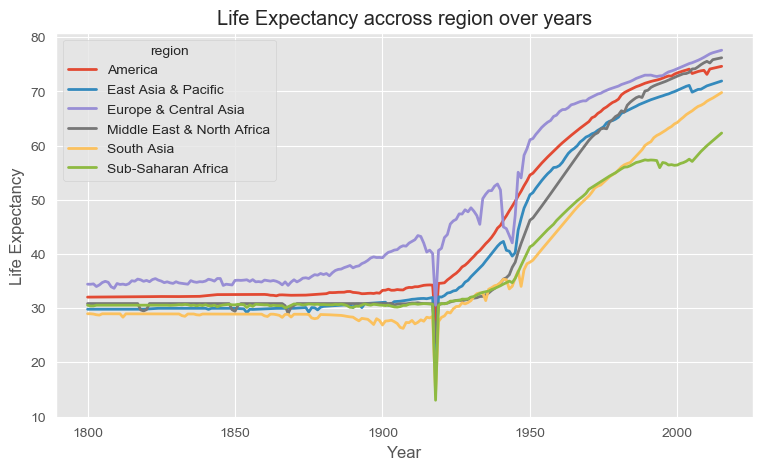

In [28]:
test = df.groupby(['Year','region']).life.mean().unstack()
test.plot(figsize=(9,5), title='Life Expectancy accross region over years', linewidth=2.0)
plt.ylabel('Life Expectancy');

Do the latest developments of medicines has played a role? A lot of deceases are recoverable due to the development of advanced medicine and procedures. We see consistent growth in life expectancy post-1950.

# Regression Analysis
Regressions models help to examine the linear relationships between two (Simple regression) or more variables (Multiple regression). I will be using both using statsmodel sci-kit learn python libraries respectively.

In [29]:
# Load necessary ML libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer,MinMaxScaler,StandardScaler,Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import adjusted_rand_score, homogeneity_score
from sklearn.metrics.cluster import completeness_score

**Analyzing correlations before building model**

Heatmaps visualizes the correlations among the features. With time series analysis and scatter plots, there was visible positive correlations between the year, income variables with the life expectancy. This step is crucial while developing the regression model as Income, and Year variables can be good predictors to measure life expectancy.

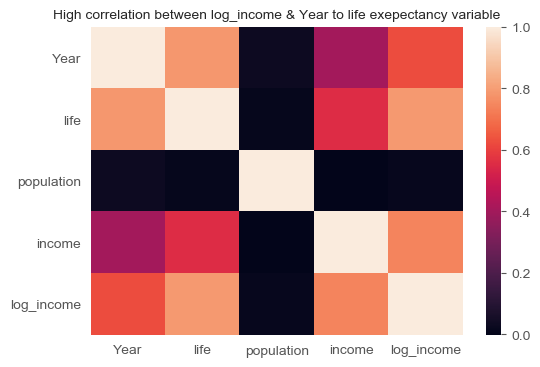

In [30]:
#plot the correlation
plt.figure(figsize=(6,4))
sns.heatmap(df.corr())
plt.title('High correlation between log_income & Year to life exepectancy variable',fontsize=10);

In [31]:
df.corr()

,Year,life,population,income,log_income
Year,1.000000,0.785039,0.029549,0.402331,0.625417
life,0.785039,1.000000,0.013618,0.557327,0.790444
population,0.029549,0.013618,1.000000,-0.001939,0.014975
income,0.402331,0.557327,-0.001939,1.000000,0.743768
log_income,0.625417,0.790444,0.014975,0.743768,1.000000


**Prepare the dataset with dummy variables**

It is vital to use essential features and try to get an accurate model as much possible. Pandas come with get_dummies methods which converts the categorical columns to numerics vectors which are more understandable to machine learning algorithms. Here we create a new column of dummy variable(numeric) such that numbers represent regions. Now let's divide the dataset into X (input variable) and y (response variable) dataset.

In [32]:
region = pd.get_dummies(data=df['region'], drop_first=True)
df_dummy = pd.concat([df,region],axis=1)

In [33]:

# Check the region column as been one hot encodeded
df_dummy.head(2)

,Country,Year,life,population,income,region,log_income,East Asia & Pacific,Europe & Central Asia,Middle East & North Africa,South Asia,Sub-Saharan Africa
0,Afghanistan,1800,28.211000,3.280000e+06,603.0,South Asia,6.403574,0,0,0,1,0
1,Afghanistan,1801,28.200753,1.321200e+07,603.0,South Asia,6.403574,0,0,0,1,0


In [34]:

# change the column names to short names for convention.
df_dummy.columns = ['Country', 'Year', 'life', 'population','income','region','log_income','eastasia','europe','mideastn','southasia','sahafrica']

In [35]:
# prepare input and target data frames.
X = df_dummy[['log_income','Year','population','eastasia','europe','mideastn','southasia','sahafrica']]
# taget 
y = df_dummy['life']

**Very important step of Train-test split,scaling and Imputing**

Gapminder dataset contains Income, Year and life expectancy features highly varying in magnitudes, units, and range. The features with high magnitudes may introduce wrong calculations while calculating distances over lower magnitude variables. To prevent this we can use the sklearn's preprocessing library to scale the data.

Similarly, use train test split method that allows us to test our model against the validation set and avoids overfitting be reducing the bias, as standard practice we can use 80% of data for training and 20% of data for testing.

In [36]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale each features 
scaler = StandardScaler()

# Repeat with the scaler - Since variables are different scale 
X_train = scaler.fit_transform(X_train)
#print(X_train[:10])
X_test = scaler.transform(X_test)

# Create the regressor: lm
lm = LinearRegression()

# Fit the regressor to the training data
lm.fit(X_train,y_train)

#Predcit train data
preds_train = lm.predict(X_train)

# Predict on the test data
y_pred = lm.predict(X_test)

# Compute and print R^2 and MAE
print("R-Sqaured: {}".format(lm.score(X_train,y_train)))
mae = metrics.mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
print("Mean Absolute Error: {}".format(mae))
print("Root Mean Squared Error: {}".format(rmse))

R-Sqaured: 0.7724254168821179
Mean Absolute Error: 6.210535609741695
Root Mean Squared Error: 7.788272658225369


We are covering good amount of variance the model is able to explain 77%. Errors are not bad as well. Here I considered calculating mean absolute error which measures the magnitude of errors in set of predictions in sample test dataset. So we can say our predictions are off by 6.21 years on an average.

**Model coefficients evaluation Sklearn**

The bar chart below tells us which weights of the coefficients and their importance. High weighted coefficients will have a more significant impact on the model than the low weighted. Income and Year column has the most significant impact on our model. Indeed, while income positively correlated to life expectancy the time series analysis showed as years pass by the life expectancy has shown an exponential shift.

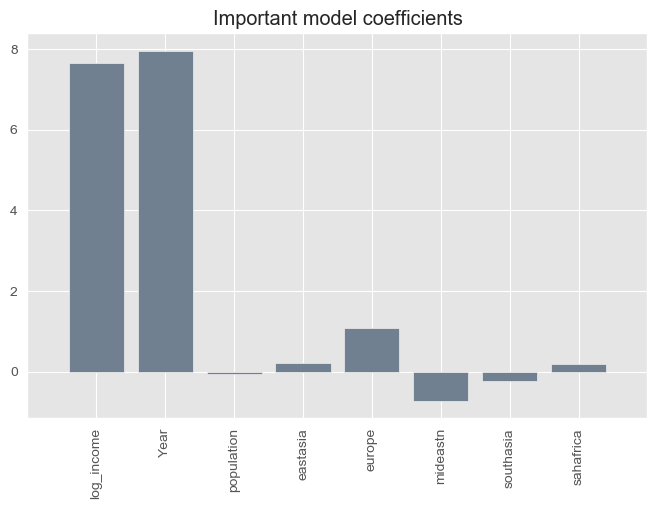

In [37]:
plt.figure(figsize=(8, 5))
plt.bar(np.arange(lm.coef_.shape[0]), lm.coef_,color='slategrey')
plt.xticks(np.arange(lm.coef_.shape[0]), X.columns, rotation='vertical')
plt.xlim([-1, lm.coef_.shape[0]])
plt.title("Important model coefficients");


In [38]:

print("Intercept: {}".format(lm.intercept_))
print("Coefficients: {}".format(lm.coef_))

Intercept: 42.95941098277664
Coefficients: [ 7.65603458  7.96301909 -0.06289889  0.20246534  1.08899031 -0.72282782
 -0.24488211  0.17511097]


We have intercept 42.96 So given all our input variables 0 or constant, we can expect life expectancy of the country around 43 Years, which exactly what we see initially in summary statistics

**Actual vs Predictions using Sklearn regression**
It was also interesting to take a look at how the predicted values relate to actual values. All the points should lie on the black dotted line (y=x) assuming that our model is perfect. However, it is not, and we see the errors in the predictions when we applied our model on the test dataset.

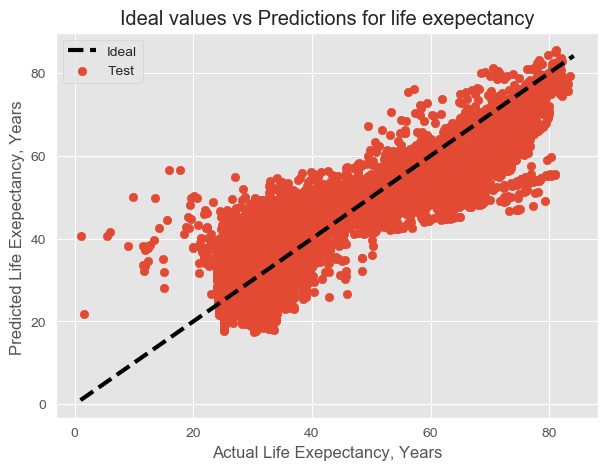

In [39]:
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, label="Test")
plt.title("Ideal values vs Predictions for life exepectancy")
plt.xlabel("Actual Life Exepectancy, Years")
plt.ylabel("Predicted Life Exepectancy, Years ")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3, label="Ideal")
plt.legend(loc="upper left",fontsize=10);

**Regression Statistical hypothess Testing**

It is always important to have statistical significance associated with the predictive model. Python statsmodel package provides facility to test statistical results dervied from the model.

**Important note about scaling**

The important thing to notice between the sklearn module and stats model is the scaling. We cannot use standard scaler like we used in sklearn, hence I am eliminated all other variables that cannot be scaled well using just log function. So here I am simply predicting log_income to the life expectancy

In [40]:
lm = 'life ~ log_income'
# use the ordinary least squares and fit the model
#x_train = sm.add_constant(X_train)
model = smf.ols(formula=lm,data=df).fit()
#print model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   life   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                 6.875e+04
Date:                Mon, 29 Apr 2019   Prob (F-statistic):               0.00
Time:                        08:20:47   Log-Likelihood:            -1.5337e+05
No. Observations:               41284   AIC:                         3.068e+05
Df Residuals:                   41282   BIC:                         3.068e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -46.5325      0.345   -135.063      0.000     -47.208     -45.857
log_income    11.8107      0.045    262.193      0.000      11.722      11.899
==============================================================================
Omnibus:                     2954.131   Durbin-Watson:                   0.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4254.005
Skew:                           0.603   Prob(JB):                         0.00
Kurtosis:                       4.010   Cond. No.                         54.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
print("Intercept: {}".format(model.params[0]))

Intercept: -46.53253968339353


In [42]:
print("Coefficient: {}".format(model.params[1]))

Coefficient: 11.810727134480839


**Predictions using stats Models**

In [43]:
# get some sample data from X for testing
X = df['log_income']
y = df['life']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# X_test data generated for testing
y_preds = model.predict(X_test)
mean_absolute_error(y_test, y_preds)

7.579530508040644

As we can see the mean absolute error is close to the model developed by sci-kit learn, sci-kit learn the error is small as we have used multiple features however the prediction error is not that bad.

**Interpretation of statistical table**

Adjusted R-squared - Reflects the fit of the model, the proportion of the variance explained. Higher R values generally indicates a better fit in our case it is 62.5, is it good - hard to say every domain has different threshold values.
Intercept - If all the coefficients are zero, then the expected output Y would be equal to the const or intercept coefficient but in our case, we have significant coefficients for income column and life expectancy cannot be negative.

Coefficient - Represents the change in the output Y due to a change of any of X,for e.g., in this case Y will increase every additional 1 unit (We have taken log of income) increase in GDP we see increase with the increase in life expectancy by 11.81 years.

std err - In statsmodel the std error reflects the level of accuracy of the coefficients. So lower the error higher is the accuracy.

Hypothesis Testing and p-values - P values indicate that the coefficients are statistically significant; in this case, they are smaller 0.05 cut off; hence we can say the results the results plotted using our coefficients are not by random chance.

To understand theory of the stats table I reffered to the site below

[1] Reference: https://datatofish.com/statsmodels-linear-regression/ (Details in references section at the end)

**How Well Does the Model Fit the data ?**

The plot code section has been taken from the below link which provided during ADS class.

[2] Reference:https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034 (Details in references section at the end)

**QQ Plot**

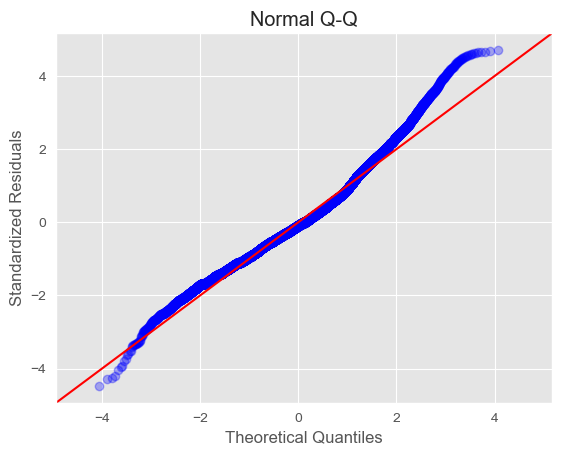

In [45]:
## QQ Plot
residuals = model.get_influence().resid_studentized_internal

# import probability plot
from statsmodels.graphics.gofplots import ProbPlot

q_plot = ProbPlot(residuals)
q_prob = q_plot.qqplot(line='45', alpha=0.3, color='blue', lw=2)

# add title, x and y labels
q_prob.axes[0].set_title('Normal Q-Q')
q_prob.axes[0].set_xlabel('Theoretical Quantiles')
q_prob.axes[0].set_ylabel('Standardized Residuals');

Along with distribution plots we used in sklearn, qqplot is way to check if the residuals are normally distributed In this case we can see that the residuals aligned with straight line and indicate normal distribution. At the end the residuals get away from line that's because the presence of outliers

**Residual vs Fitted plot**

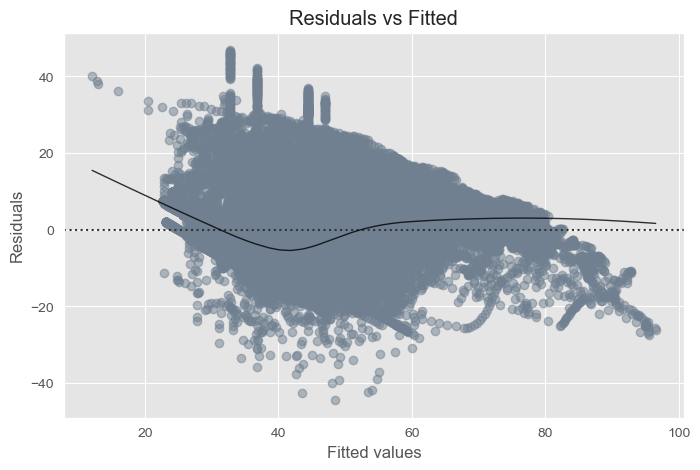

In [46]:
model_fitted_y = model.fittedvalues
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(5)
plot_lm_1.set_figwidth(8)

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'life', data=df_dummy, lowess=True, scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'black', 'lw': 1, 'alpha': 0.8},color='slategray')

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

This plot shows that if residuals have linear or non-linear patterns, we can see some polynomial distribution of residuals they are not precisely random as we would expect. However the plot looks ok and relatively shapeless and even distributions of the point on either side of the line, residuals get smaller as we go from left right and this effect of outliers, it's not worth to over-interpret. The overall distribution of data is random and that's right sign residuals do not contradict the linear assumption especially when the life expectancy values between 50-80

**Scale location plot**


In [47]:
# fitted values 
fitted_values = model.fittedvalues

# absolute squared normalized residual values
abs_sqrt_normalized_residuals = np.sqrt(np.abs(residuals))

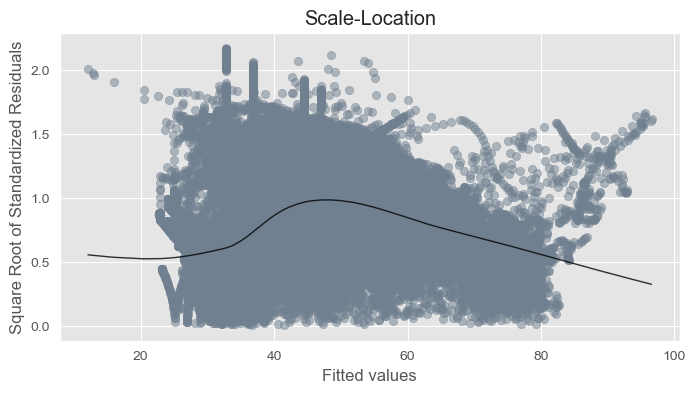

In [48]:
fig=plt.figure(figsize=(8,4))

# to plot this we need to overalay a scatter plot with the regplot

plt.scatter(fitted_values, abs_sqrt_normalized_residuals, alpha=0.5,color='slategray')
sns.regplot(fitted_values, abs_sqrt_normalized_residuals, scatter=False, ci=False, lowess=True,
            line_kws={'color': 'black', 'lw': 1, 'alpha': 0.8})

fig.axes[0].set_title('Scale-Location')
fig.axes[0].set_xlabel('Fitted values')
fig.axes[0].set_ylabel('Square Root of Standardized Residuals');


This plot will show the condition of homescadity, whether how the residuals are spread for different predictors.
In other way we can check assumption of equal variance (homoscedasticity). A Good plot shows a horizontal line with equally (randomly) spread points. In this particular case, the line starts as flatten and then goes up showing the residuals for thos independent variable are more spread out is somewhat heteroscedastic (i.e. non-uniform variance) in the middle of the range.

# K-means cluster Analysis
Clustering is an unsupervised machine learning technique tries to groups properties of data or division of data based on discrete labeling. K-means is one most popular clustering algorithm which searches for a pre-defined number of clusters within an unlabeled dataset Let start by taking a copy of existing data frame.

**Data Preparation**

As ML algorithm works with the numerical dataset, we need to convert the region our target variable to numerics using pandas replace method

In [49]:
# Lets take a copy of our dataset
df2= df.copy()

In [50]:

# Let's convert the target variable to numerics

region = {'South Asia':0, 'Europe & Central Asia':1,
       'Middle East & North Africa':2, 'Sub-Saharan Africa':3, 'America':4,
       'East Asia & Pacific':5}

df2['region'] = df2['region'].replace(region)

As there are 6 regions we can try to fit the data in 6 clusters however we can also verify the same using the elbow method to find the optimal clusters

Lets distribute the data into X and y dataframes and convert them to array's (unlabled data)

In [51]:
#  Create inpute and Target dataframe using available features.
X = np.array(df2[['life','log_income']])
y = np.array(df2[['region']])

Though we know we need to 6 clusters as we 6 regions , it is always better to obtain optimal clusters using the elbow method the below code genrates the elbow graph to let us verify the number of cluster assignments.

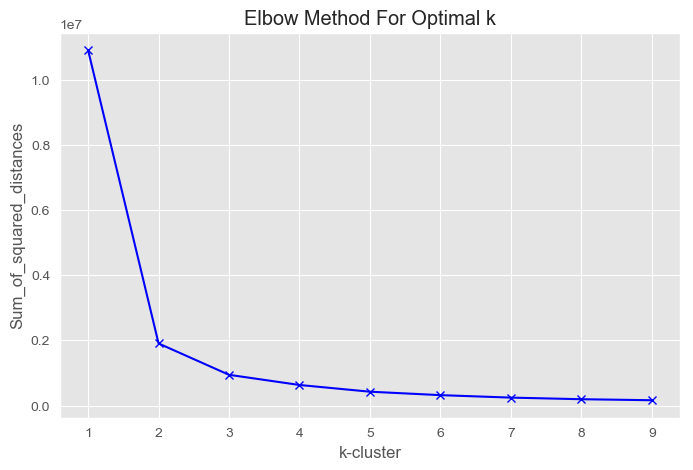

In [52]:
plt.figure(figsize=(8,5))
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k-cluster')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [53]:
# Split the train test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

As we can see the line kind of flattens out at 3 , but since there are 6 different region I would interested in classifying them impartially. We have already imported the liberaries, next is to use KMeans functions that takes argument with number of clusters

In [54]:
kmeans = KMeans(n_clusters=6,algorithm = 'auto')
kmeans.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [55]:
y_kmeans = kmeans.predict(X_test)

**Confusion matrix and Classification report**

In [57]:
print(classification_report(y_train,kmeans.labels_))

              precision    recall  f1-score   support

           0       0.09      0.39      0.15      1380
           1       0.28      0.11      0.16      8384
           2       0.04      0.04      0.04      3428
           3       0.40      0.15      0.22      8470
           4       0.25      0.16      0.19      6350
           5       0.13      0.34      0.19      5015

   micro avg       0.17      0.17      0.17     33027
   macro avg       0.20      0.20      0.16     33027
weighted avg       0.25      0.17      0.17     33027



Not bad , we were able to map the points into 6 distinct clusters and we can visualize the same using the scatter plot. We can clearly e clusters are aligned as per the region's life expectancy and income

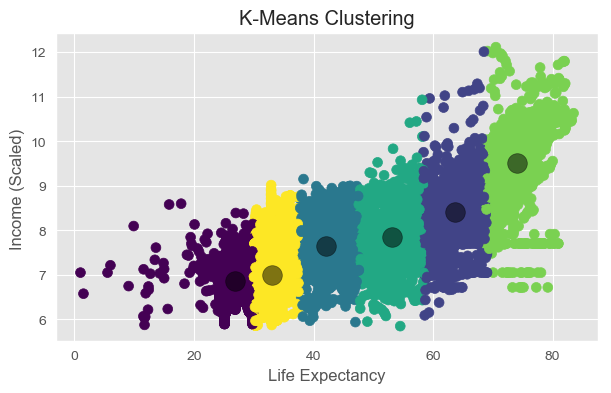

In [58]:
fig = plt.figure(figsize = (7,4))
ax = fig.add_subplot(111)
scatter = ax.scatter(X_test[:, 0],X_test[:, 1], c=y_kmeans, s=50,cmap=plt.cm.get_cmap('viridis',6))

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
ax.set_title('K-Means Clustering')
ax.set_xlabel('Life Expectancy')
ax.set_ylabel('Income (Scaled) ');

**How well the clustering is performing ?**

Unsupervised learning is tricky we don't have standard metrics to calculate the accuracy mainly because we deal with the unlableled data. However SKlearn have two standard metrics that can verify how well the clustering is working

Both the below metrics are in range of 0 - 1 and normally higher the values are better. The Sci-kit learn page shows below defination of both of these parameters [3]

"homogeneity: each cluster contains only members of a single class."
"completeness: all members of a given class are assigned to the same cluster"
[3] Reference - https://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness-and-v-measure (Details are in reference section at the end)

In [59]:
# Perform the numpy shaping for artihmatics
y_true = np.array(y_test).ravel()

**Homogenity of cluster (0-1) higher is better**

In [60]:
hs = homogeneity_score(y_true,y_kmeans)
hs = round(hs,3)
print("Homegenity Score of K-means: {}".format(hs))

Homegenity Score of K-means: 0.044


**Completeness of cluster (0-1) higher is better**

In [61]:
cs = completeness_score(y_true,y_kmeans)
cs = round(cs,3)
print("Completeness Score of K-means: {}".format(cs))

Completeness Score of K-means: 0.045


In our case both the score are really poor almost to zero that means though we are able see clusters based on it life expectancy and income. Overall the unsupervised approach using k-means was not a good fit for classifying the regions using life expectancy and GDP and we may need some alternatives to obtain better score.

# Findings and Analysis Report
As learned it in Applied data science class, the epicycles of analysis is a highly iterative process and often starts with asking the right questions.

So here I want to present my findings obtained through various iterations of questions and analysis during the project. A well-formatted data is the ideal platform for performing analysis. Using the clean data function, helped me to clean the data such as converting the population column to numerics, imputing group wise mean and median values to missing rows. As a result, I was able to retain the class balance across regions, countries and prevented the information loss.

How is the data distribution? Do we observe normal/power-law or skewed distributions?
The Gapminder dataset contains the census information from 197 countries and 6 regions around the world. Histograms showed that the life, population and income variables are not normally distributed and with a significant presence of outliers I decided to take a log of income column and define a new variable as 'log_income.' Another reason to take logarithms was the presence of a correlation between income and life variables.

What are the regions or countries that have the highest life expectancy
The median life expectancy of Europe and Central Asia found to be highest followed life expectancy America, East Asia, and Pacific. The life expectancy was very low before 1950 somewhere in the range of 30-40 years. Low life expectancy before the1950 can be associated with various events such as world war, no advanced medical practices. This fact resurfaced during the time series analysis as we see visible exponential growth in the life expectancy post year 1975.

What is most densely populated region and country?
South Asia found the most densely populated region with countries like China and India. South Asia experienced rapid growth in population compared to other regions, after the year 1950 compared to most other regions, we can also cross verify the same on google trends by searching population for India or China.

Do we have any correlation between features?
Income and Year have significant positive correlations with life expectancy. Data scaling also helped to improve the correlation between 'log_income' and 'Life expectancy' column. The Pearson coefficient shifted to 0.81 from 0.55 post the scaling activity, and it was also a good breakthrough for developing linear regression model.

Can we predict the life expectancy? what are the most powerful features to perform regression?
I found a multiple linear regression model was a good fit here especially with the help of sci-kit learn library compare to the state model. Stats models have some good features of testing p-values and residual plots but significantly lacks the preprocessing libraries that are available with sci-kit learn. The sci-kit lean model predicted life expectancy with the mean absolute error of 6.21 years on the unseen data which is not bad. Both the models (sci-kit learn and stats model) also covered a decent amount of variance. I verified the goodness of fit using actual vs. predictions graph and residual graphs. Both proved that the linear model was a good enough fit with some predictions errors which is very realistic.

Can we statistically test our model that predicts the life expectancy?
The Ordinary Least square method from stats model gives an excellent way to statistically test the model, in OLS method we tried to predict the life expectancy using just the income column and observed that the p-values were less than cut off 0.05 that means our model

What property does the residual shows heteroscedasticity or homoscedasticity?
Residuals plot showed us homoscedasticity property. The residual vs. fitted graph was relatively shapeless. Even distributions of the points on either side of the line, residuals observed to get smaller as we go from left right and that could be the effect of outliers however overall it did not contradict the linear assumption. Similarly, the QQ plot residuals aligned with a straight line and indicating the normal distribution.

If we do unsupervised model, can we cluster the data using available features.
We were able to obtain clusters using a K-means unsupervised approach that processes numerical features such as income and life expectancy to classify the data points in various regions.

If yes, what optimal number of clusters need to fit data?
Using the elbow method we found that the 3 clusters were optimal to classify the data. However, I decided to go with 6 clusters since have 6 distinct regions. I want to go for an equal class balance in my target variable.

Do we have accuracy metrics to represent cluster assignment?
Though clustering was not significantly intuitive with homogeneity and completeness score close to zero, we were still able to visualize clusters along with the centers and explore the clustering analysis.

I performed many cycles of data analysis process in past two weeks so as to answer the new questions that were arriving from my previous analysis.In the end were able to get most our answers to the questions I asked befor begining the project. I hope it was able to deliver the project expectations,it was great experience to analyze Gapminder dataset.

# Acknowledgements
I would like to thank the professor Olga Scrivner and Meghesh Patil for the excellent content,guidance and support during this project and throughout the semester, it has been a great learning experience. Also, I would also like to extend my appreciation to online refereces mentioned in the report for allowing me to gather meaningful insights.

# References
[1] Data to Fish, (2019, March 29). Use statsmodels to Perform Linear Regression in Python. Retrieved April 23, 2019, from https://datatofish.com/statsmodels-linear-regression/

[2] Can, E. (2017, July 12). Emulating R regression plots in Python. Retrieved April 21, 2019, from https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034

[3] Sci-kitlearn.org,Clustering.Retrieved April 23, 2019, from https://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness-and-v-measure